Original Columns: Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')
Transformed Data Sample:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water             None   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans             None   
4      s5  TV Show           Kota Factory             None   

                                                cast        country  \
0                                               None  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...           None   
3                                               None           None   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K... 

C:\Users\USER\AppData\Local\Temp\ipykernel_1708\3051566342.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="coolwarm")


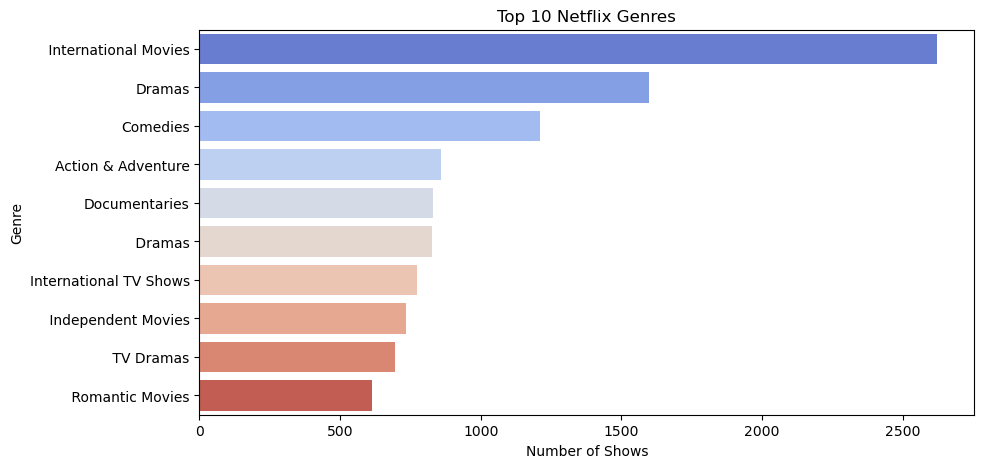

In [13]:
import pandas as pd
import mysql.connector
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------- Extract Phase ---------------------- #
file_path = "Netflix_titles.csv"  # Ensure correct path
df = pd.read_csv(file_path)

# Print columns to debug
print("Original Columns:", df.columns)

# ---------------------- Transform Phase ---------------------- #
# Normalize column names (strip spaces & lowercase for consistency)
df.columns = df.columns.str.strip().str.lower()  # Convert all to lowercase

# Fix 'date_added' issue
if 'date_added' in df.columns:
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')  # Convert to datetime
else:
    print("Warning: 'date_added' column not found in the dataset!")

# Fill missing values with None (so MySQL understands them as NULL)
df = df.replace({np.nan: None})

# Show sample data
print("Transformed Data Sample:")
print(df.head())

# ---------------------- Load Phase ---------------------- #
# Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="12345678",
    database="netflix_db"
)
cursor = conn.cursor()

# Create table if not exists
create_table_query = """
CREATE TABLE IF NOT EXISTS netflix_titles (
    show_id VARCHAR(50) PRIMARY KEY,
    type VARCHAR(20),
    title TEXT,
    director TEXT,
    country TEXT,
    date_added DATE,
    release_year INT,
    rating VARCHAR(20),
    duration VARCHAR(20),
    listed_in TEXT,
    description TEXT
);
"""
cursor.execute(create_table_query)

# Prepare SQL Insert Statement
insert_query = """
    INSERT INTO netflix_titles 
    (show_id, type, title, director, country, date_added, release_year, rating, duration, listed_in, description)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    ON DUPLICATE KEY UPDATE 
        type=VALUES(type),
        title=VALUES(title),
        director=VALUES(director),
        country=VALUES(country),
        date_added=VALUES(date_added),
        release_year=VALUES(release_year),
        rating=VALUES(rating),
        duration=VALUES(duration),
        listed_in=VALUES(listed_in),
        description=VALUES(description);
"""

# Insert data row by row
for _, row in df.iterrows():
    cursor.execute(insert_query, (
        row['show_id'], row['type'], row['title'], row['director'], row['country'],
        row['date_added'], row['release_year'], row['rating'], row['duration'],
        row['listed_in'], row['description']
    ))

# Commit and close connection
conn.commit()
conn.close()

print("✅ ETL Process Completed Successfully!")

# ---------------------- Data Visualization ---------------------- #
# Split multiple genres
df_exploded = df.assign(listed_in=df['listed_in'].str.split(',')).explode('listed_in')

# Count shows by genre
genre_counts = df_exploded['listed_in'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="coolwarm")
plt.xlabel("Number of Shows")
plt.ylabel("Genre")
plt.title("Top 10 Netflix Genres")
plt.show()
